In [1]:
import sys
sys.path.append("/workdir/unsupervised_pretrain/")

In [2]:
import numpy as np
import json
import torch
from InstructorEmbedding import INSTRUCTOR
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# Load and embed #

In [3]:
device = torch.device("cuda")

In [4]:
embed_model = INSTRUCTOR("hkunlp/instructor-xl").to(device)
embed_model.max_seq_length = 4096

load INSTRUCTOR_Transformer
max_seq_length  512


In [5]:
with open("/datasets/datasets/unsupervised-sentinel2/testset-16SEF/testset-16SEF-512.json", "r") as f:
    data = json.load(f)

In [6]:
instruction = "Represent the geospatial data (the number, proportion, and description of geographic features) for clustering:"

In [7]:
pairs = []
for datum in data:
    pairs.append([instruction, datum])

In [8]:
embeddings = embed_model.encode(pairs)

In [9]:
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Visualize #

In [10]:
tsne = TSNE(n_components=2, random_state=0)

## Directly from `instructor-xl` ##

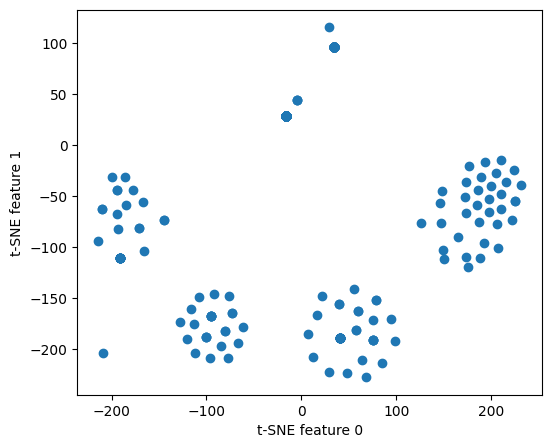

In [11]:
data_2d = tsne.fit_transform(normalized_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

## From `.npy` files ##

In [12]:
import glob
npy_embeddings = []
for filename in glob.glob("/datasets/datasets/unsupervised-sentinel2/testset-16SEF/*.npy", recursive=True):
    npy_embeddings.append(np.load(filename))
npy_embeddings = np.concatenate(npy_embeddings, axis=0)
npy_embeddings = npy_embeddings / np.linalg.norm(npy_embeddings, axis=1, keepdims=True)

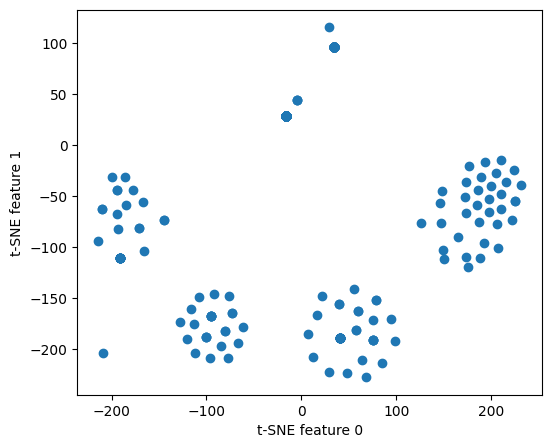

In [13]:
data_2d = tsne.fit_transform(npy_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

## From `SeriesEmbedDataset` ##

In [14]:
from datasets import SeriesEmbedDataset

In [15]:
ds = SeriesEmbedDataset(["/datasets/datasets/unsupervised-sentinel2/testset-16SEF/"], size=512, series_length=20)

In [16]:
ds_embeddings = []
with torch.inference_mode():
    for i in tqdm(range(0, len(ds), 2)):
        _, _, embedding = ds[i]
        ds_embeddings.append(embedding.reshape(1,-1))
ds_embeddings = np.concatenate(ds_embeddings, axis=0)

  0%|          | 0/441 [00:00<?, ?it/s]

In [17]:
ds_embeddings /= np.linalg.norm(ds_embeddings, axis=1, keepdims=True)

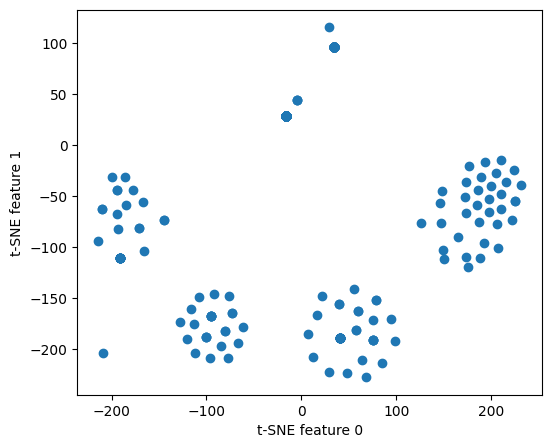

In [18]:
data_2d = tsne.fit_transform(ds_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()